In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from tabnet_keras import TabNetRegressor, TabNetClassifier





In [23]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
# from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection


In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('Using GPU:', gpus[0])  # In ra tên của GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
else:
    print('No GPU found. Using CPU.')

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [25]:
save_dir=f"{exps_dir}/exp2/exp_base"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [26]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [27]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [28]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [29]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse_output=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (10331, 2)


In [30]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [31]:
x_test.shape

(5089, 33)

In [32]:
x_train.shape

(10331, 33)

In [33]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [34]:
print(x_train.shape[1])

33


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [35]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [37]:
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D, Dense
from keras.models import Model
import keras.backend as K

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=2):
    """A block that has a conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv1D(filters3, 1, strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [38]:
# early_stopping = EarlyStopping(monitor='val_loss',
#     min_delta=0.00005,
#     patience=20,
#     verbose=1,
#     restore_best_weights=True,
# )

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=7,
#     min_lr=0.000001,
#     verbose=1,
# )
# checkpoint_callback = ModelCheckpoint(
#     filepath='ResNet10.h5',  # Đường dẫn để lưu model
#     monitor='val_loss',  # Theo dõi val_loss
#     save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
#     verbose=1  # Hiển thị thông báo khi lưu model
# )

early_stopping = EarlyStopping(monitor='val_loss',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='max',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)

In [39]:
from tensorflow.keras.optimizers import Adam
from keras.layers import ZeroPadding1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# from scikeras.wrappers import KerasClassifier 

# lr=0.0001

def build_model(filters1,filters2,filters3,filters4,filters5):
    input_shape =(33,1)
    x_input = Input(shape=input_shape)

    bn_axis = -1
    step=32
    # Sử dụng filters trong hàm build_resnet_model
    # filters1 = 96
    # filters2 = filters1 * 2
    # filters3 = filters1 * 4
    # filters4 = filters1 * 6
    # filters5 = filters1 * 8
    # filters1=hp.Int('filter1', min_value=32, max_value=1024, step=step)
    # filters2=hp.Int('filter2', min_value=32, max_value=1024, step=step)
    # filters3=hp.Int('filter3', min_value=32, max_value=1024, step=step)
    # filters4=hp.Int('filter4', min_value=32, max_value=1024, step=step)
    # filters5=hp.Int('filter5', min_value=32, max_value=1024, step=step)

    learning_rate = 0.001

    x = ZeroPadding1D(padding=1)(x_input)
    x = Conv1D(64, 7, strides=2, padding='same', name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(3, strides=2)(x)

    # ResNet blocks
    x = conv_block(x, 3,[filters1, filters1, filters2], stage=2, block='a', strides=1)
    x = identity_block(x, 3,[filters1, filters1, filters2], stage=2, block='b')
    x = identity_block(x, 3,[filters1, filters1, filters2], stage=2, block='c')

    x = conv_block(x, 3, [filters2, filters2, filters3], stage=3, block='a')
    x = identity_block(x, 3, [filters2, filters2, filters3], stage=3, block='b')
    x = identity_block(x, 3, [filters2, filters2, filters3], stage=3, block='c')
    # x = identity_block(x, 3, [filters2, filters2, filters3], stage=3, block='d')
    
    x = conv_block(x, 3,  [filters3, filters3, filters4], stage=4, block='a')
    # x = identity_block(x, 3,  [filters3, filters3, filters4], stage=4, block='b')
    # x = identity_block(x, 3,  [filters3, filters3, filters4], stage=4, block='c')
    # x = identity_block(x, 3,  [filters3, filters3, filters4], stage=4, block='d')
    # x = identity_block(x, 3,  [filters3, filters3, filters4], stage=4, block='e')
    # x = identity_block(x, 3,  [filters3, filters3, filters4], stage=4, block='f')

    x = conv_block(x, 3,  [filters4, filters4, filters5], stage=5, block='a')
    # x = identity_block(x, 3, [filters4, filters4, filters5], stage=5, block='b')
    # x = identity_block(x, 3, [filters4, filters4, filters5], stage=5, block='c')
    # Repeat this pattern as needed

    # Ending layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(2, activation='softmax', name='fc1000')(x)

    # Create model
    model = Model(x_input, x, name='resnet50_1d')

    # model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
    
    return model




In [40]:
resnet50=build_model(32,96,192,256,384)
resnet50.summary()

Model: "resnet50_1d"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 1)       0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv1D)                 (None, 18, 64)       512         ['zero_padding1d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 18, 64)       256         ['conv1[0][0]']        

c:\ProgramData\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [41]:
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [42]:
resnet50.fit(x=x_train, y=y_train_onehot,
          validation_data=(x_test, y_test_onehot),
          batch_size=32,
          epochs=1200,
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/1200


323/323 [==============================] - 32s 68ms/step - loss: 0.2472 - accuracy: 0.9373 - f1_score: 0.4828 - val_loss: 0.2312 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 0.0010
Epoch 2/1200
323/323 [==============================] - 36s 111ms/step - loss: 0.2319 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.4009 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 0.0010
Epoch 3/1200
323/323 [==============================] - 36s 110ms/step - loss: 0.2316 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2680 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 0.0010
Epoch 4/1200
323/323 [==============================] - 35s 108ms/step - loss: 0.2289 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2373 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 0.0010
Epoch 5/1200
323/323 [==============================] - 35s 108ms/step - loss: 0.2258 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2629 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 0.0010
Epoc

#### * Kết quả đánh giá mô hình:

In [43]:
resnet50.summary()

Model: "resnet50_1d"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 1)       0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv1D)                 (None, 18, 64)       512         ['zero_padding1d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 18, 64)       256         ['conv1[0][0]']        

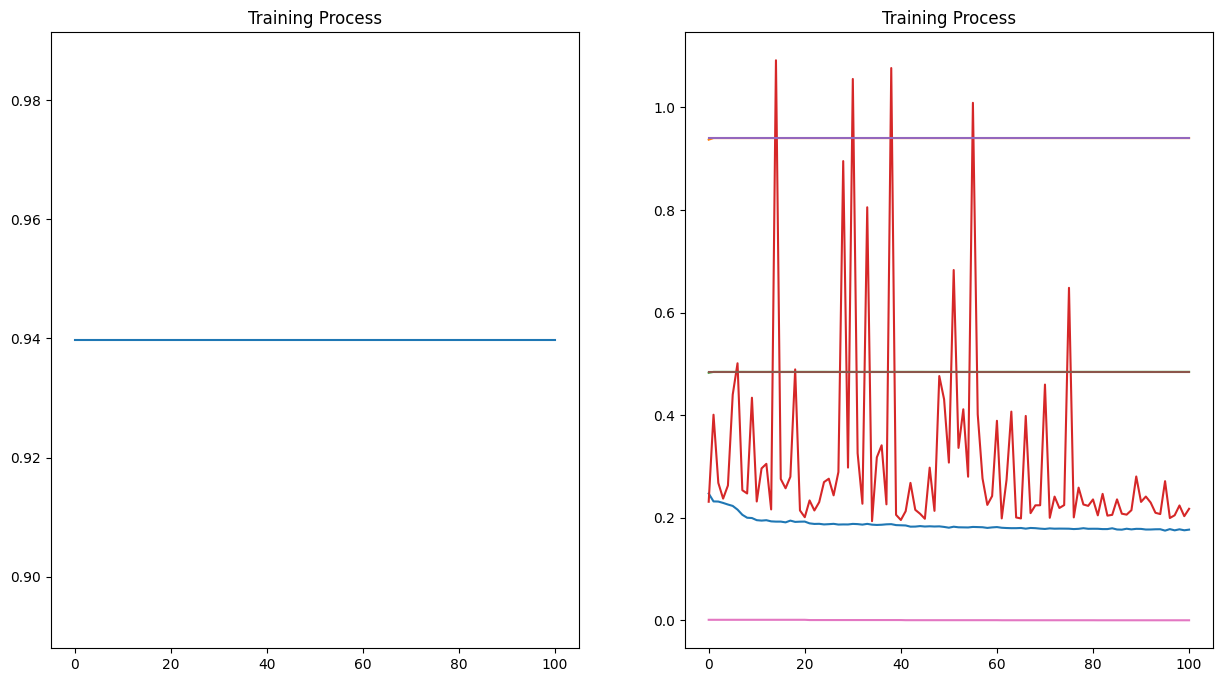

<Figure size 640x480 with 0 Axes>

In [44]:
history=resnet50.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [45]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = resnet50.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


160/160 [==============================] - 4s 20ms/step


0.9396738062487718

In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.9396738062487718
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4782
           1       0.00      0.00      0.00       307

    accuracy                           0.94      5089
   macro avg       0.47      0.50      0.48      5089
weighted avg       0.88      0.94      0.91      5089

Confusion Matrix:
[[4782    0]
 [ 307    0]]


c:\ProgramData\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

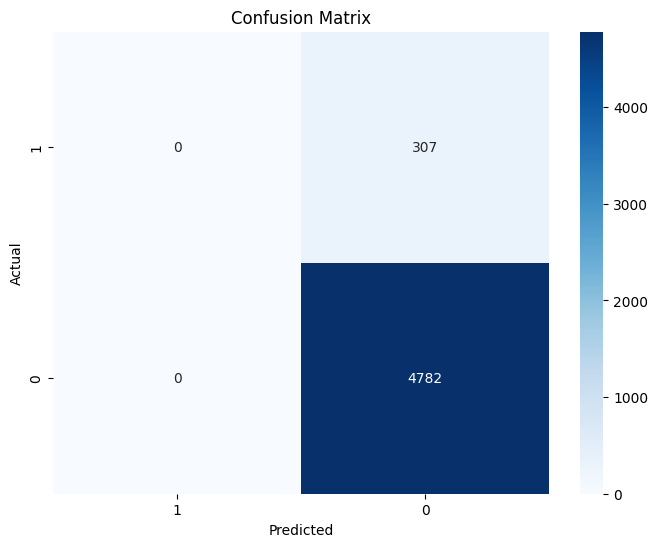

In [47]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

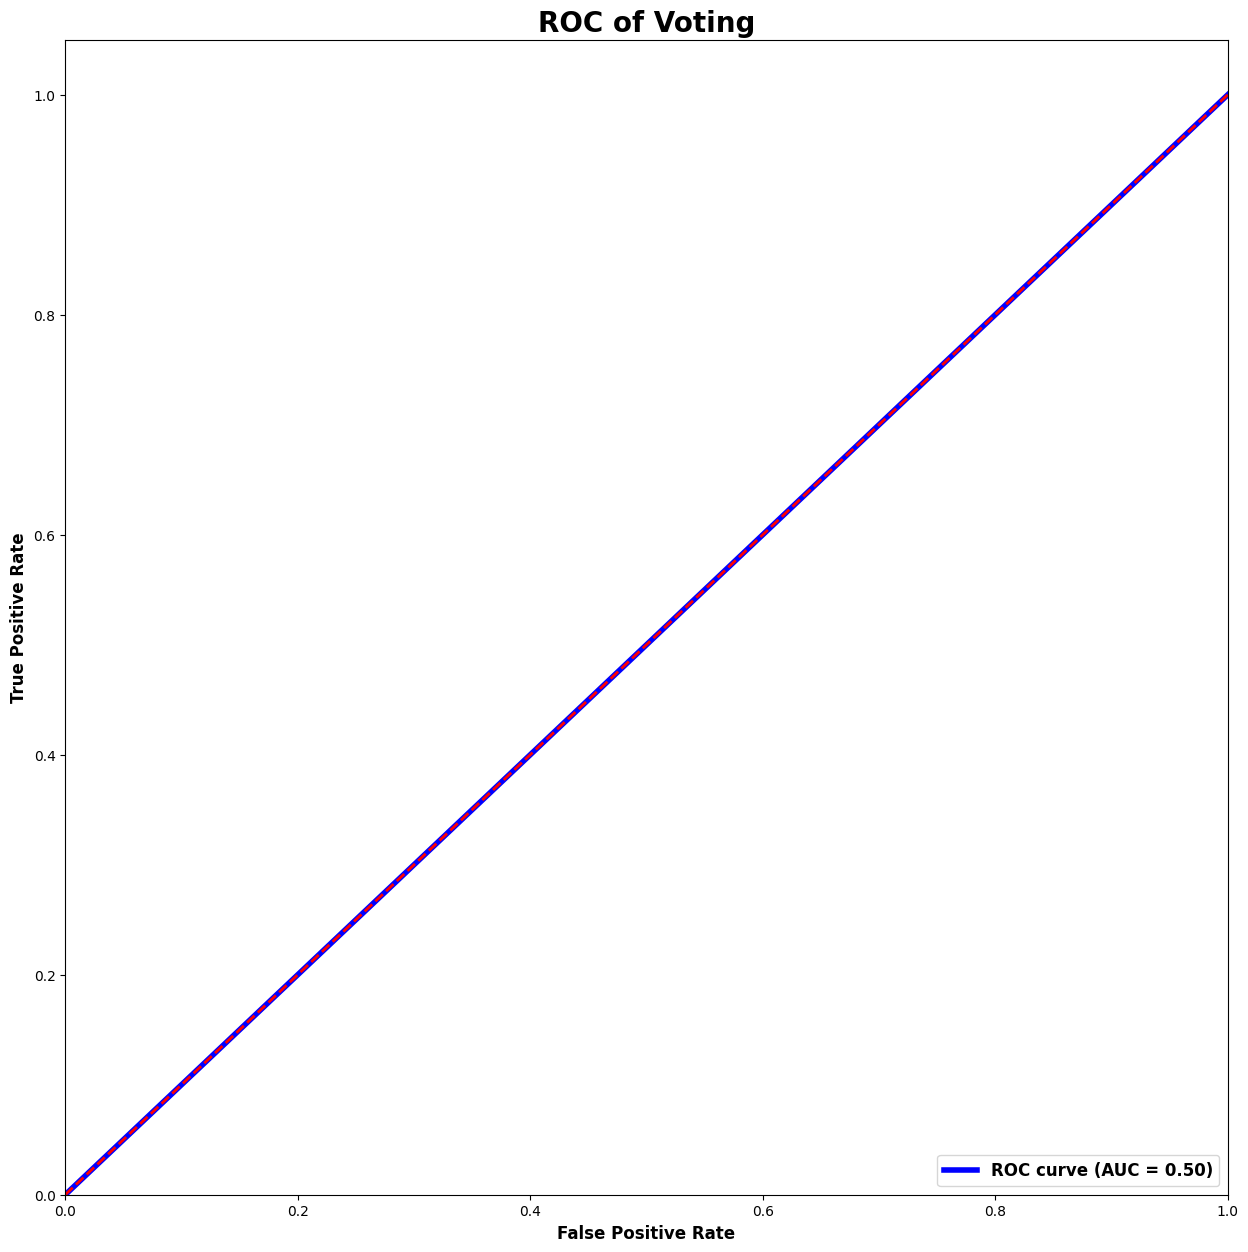

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [49]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [50]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    